In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics.pairwise import cosine_similarity


In [19]:
df = pd.read_csv("bama_cars_cleaned.csv")

# Display basic info
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   URL                         1946 non-null   object 
 1   Car Name                    1663 non-null   object 
 2   Car Year                    1663 non-null   float64
 3   Location                    1917 non-null   object 
 4   Price                       1105 non-null   float64
 5   Description                 1946 non-null   object 
 6   Mileage (KM)                1913 non-null   float64
 7   Engine Capacity (L)         1615 non-null   float64
 8   پیشرانه                     1645 non-null   object 
 9   Acceleration (s)            1168 non-null   float64
 10  Fuel Consumption (L/100km)  1364 non-null   float64
dtypes: float64(6), object(5)
memory usage: 167.4+ KB


URL                             0
Car Name                      283
Car Year                      283
Location                       29
Price                         841
Description                     0
Mileage (KM)                   33
Engine Capacity (L)           331
پیشرانه                       301
Acceleration (s)              778
Fuel Consumption (L/100km)    582
dtype: int64

In [20]:
df_cleaned = df.dropna(subset=['Car Name']).copy()

# Fill missing Price with median price of the same Car Name
df_cleaned['Price'] = df_cleaned.groupby('Car Name')['Price'].transform(lambda x: x.fillna(x.median()))

# Fill missing Mileage with median mileage of the same Car Name & Year
df_cleaned['Mileage (KM)'] = df_cleaned.groupby(['Car Name', 'Car Year'])['Mileage (KM)'].transform(lambda x: x.fillna(x.median()))

# Fill missing Engine Capacity, Acceleration, and Fuel Consumption with median values of the same Car Name
for col in ['Engine Capacity (L)', 'Acceleration (s)', 'Fuel Consumption (L/100km)']:
    df_cleaned[col] = df_cleaned.groupby('Car Name')[col].transform(lambda x: x.fillna(x.median()))


# Save the cleaned dataset
df_cleaned.to_csv("bama_cars_filled.csv", index=False)

# Check if there are any missing values left
print(df_cleaned.isnull().sum())


C:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keep

URL                             0
Car Name                        0
Car Year                        0
Location                       24
Price                         127
Description                     0
Mileage (KM)                    7
Engine Capacity (L)           210
پیشرانه                       236
Acceleration (s)              585
Fuel Consumption (L/100km)    441
dtype: int64


In [22]:
len(df_cleaned)

1663


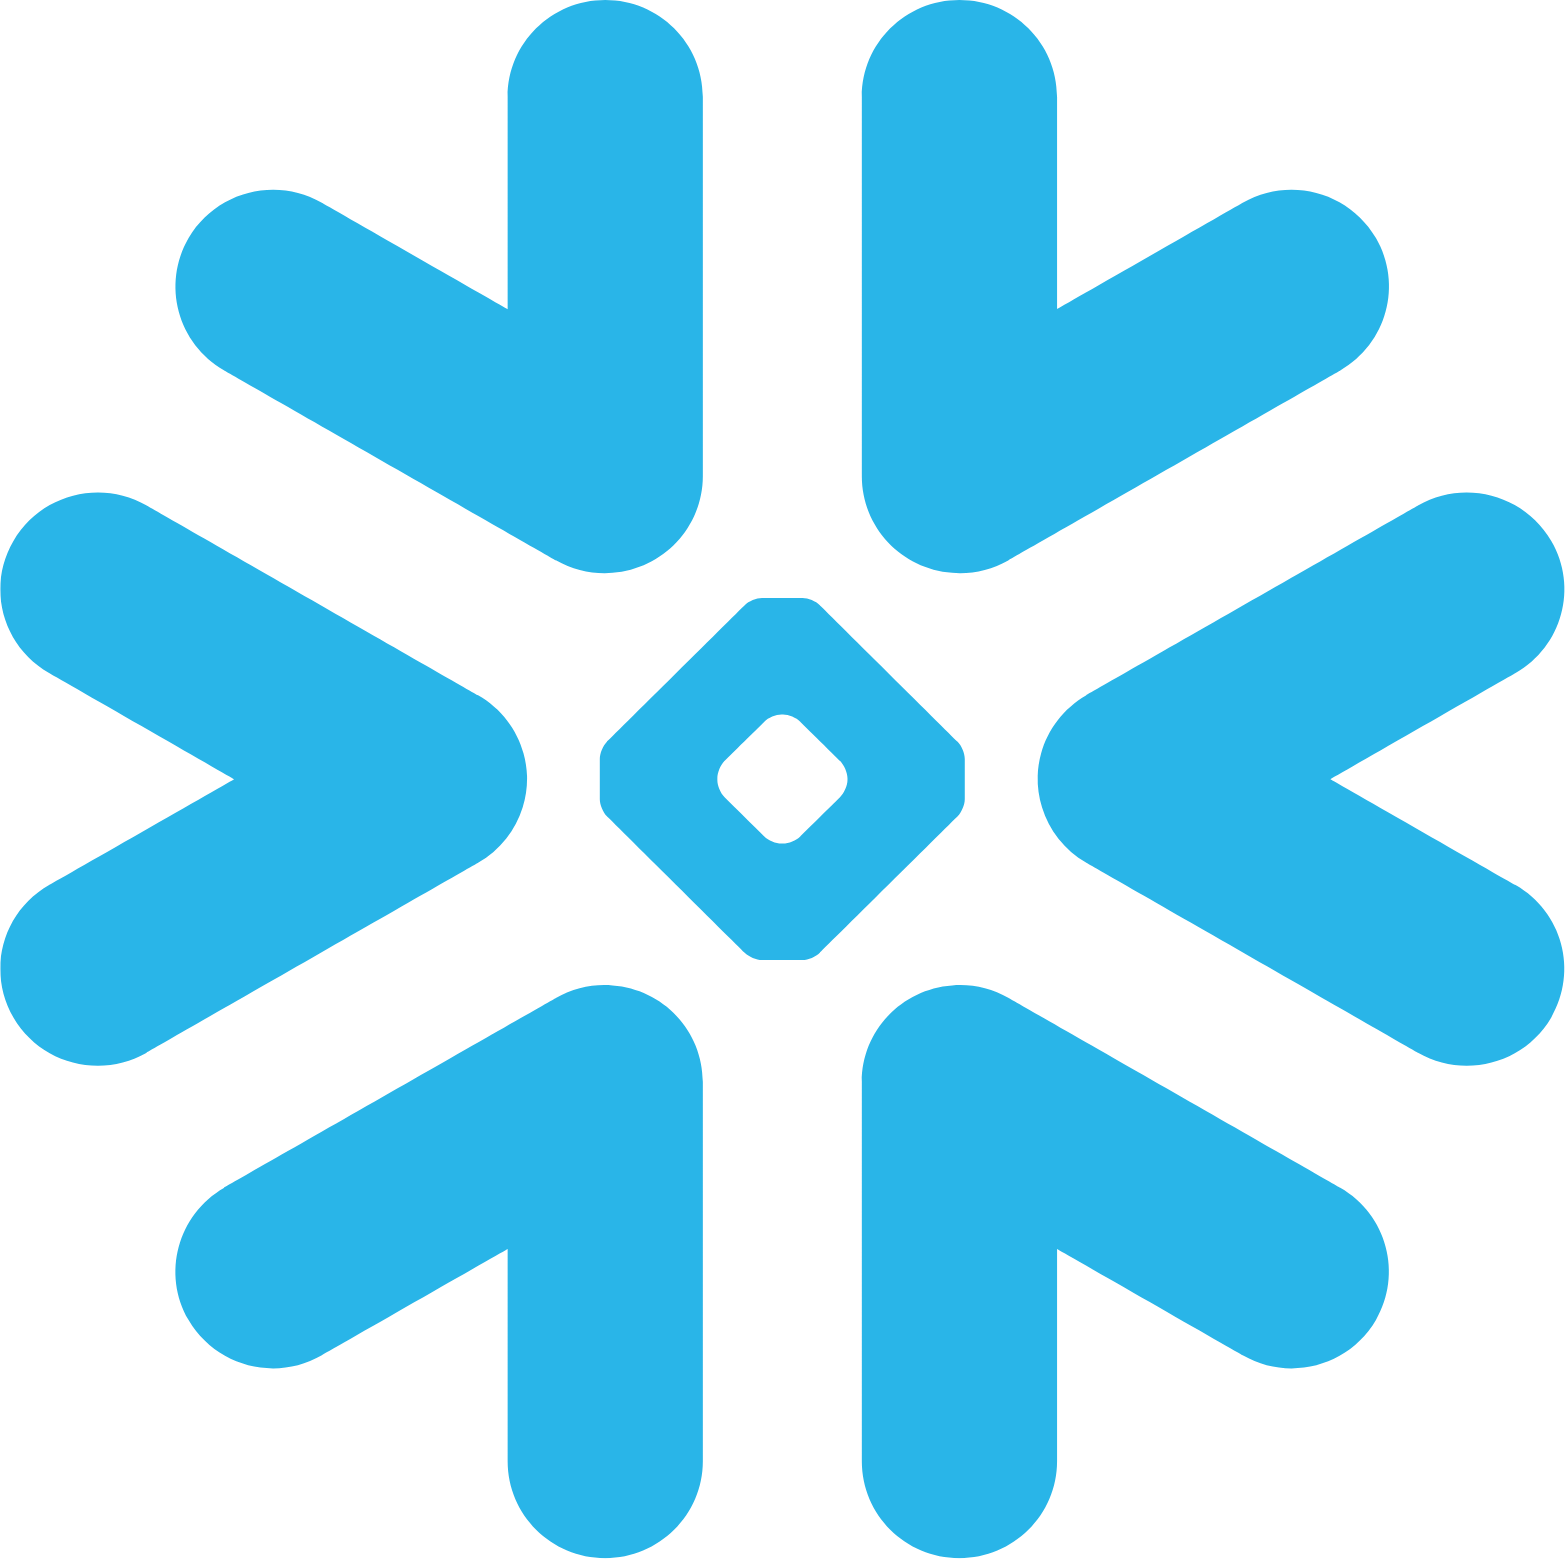

In [44]:
df = df_cleaned
df[df['Acceleration (s)'].isnull()]

In [49]:
# Drop the 'Price' column
df_iso = df.dropna(subset='Price',inplace=True)

# Select numerical features for anomaly detection
features = ['Price','Mileage (KM)', 'Engine Capacity (L)', 'Acceleration (s)', 'Fuel Consumption (L/100km)']
df_numeric = df_cleaned[features].copy()

In [50]:
# Fill missing values:
df_numeric['Mileage (KM)'] = df_numeric['Mileage (KM)'].fillna(df_numeric['Mileage (KM)'].median())
df_numeric['Engine Capacity (L)'] = df_numeric['Engine Capacity (L)'].fillna(df_numeric['Engine Capacity (L)'].mode()[0])
df_numeric['Acceleration (s)'] = df_numeric['Acceleration (s)'].fillna(df_numeric['Acceleration (s)'].mean())
df_numeric['Fuel Consumption (L/100km)'] = df_numeric['Fuel Consumption (L/100km)'].fillna(df_numeric['Fuel Consumption (L/100km)'].median())
df_numeric.isnull().sum()

Price                         0
Mileage (KM)                  0
Engine Capacity (L)           0
Acceleration (s)              0
Fuel Consumption (L/100km)    0
dtype: int64

Anomaly
 1    1459
-1      77
Name: count, dtype: int64



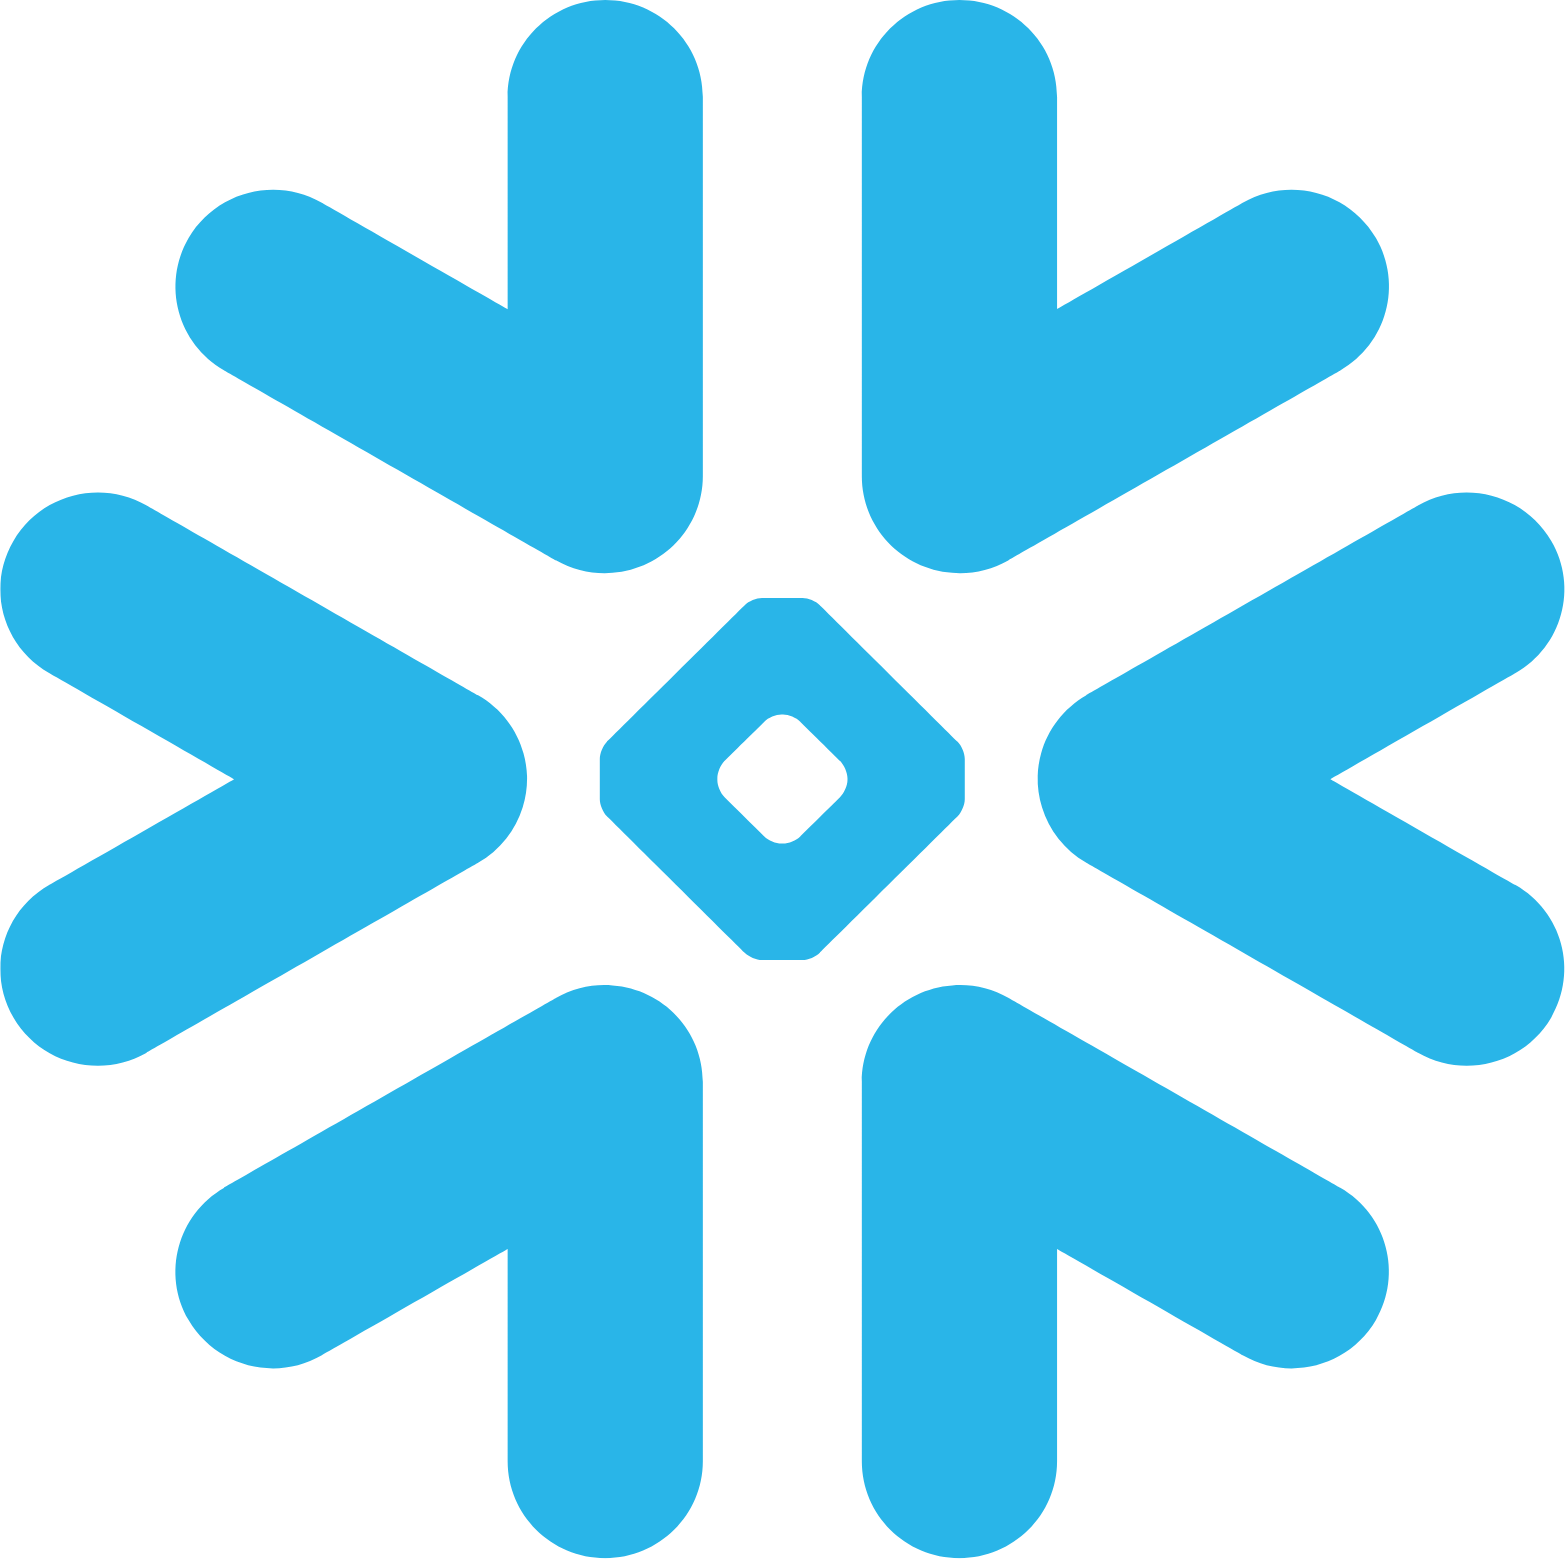

In [51]:
# Initialize Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Train the model and get anomaly scores
df['Anomaly'] = iso_forest.fit_predict(df_numeric)

# Count anomalies (-1 = outlier, 1 = normal)
print(df['Anomaly'].value_counts())

# Show detected anomalies
anomalies = df_cleaned[df_cleaned['Anomaly'] == -1]
anomalies.head()


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separate normal and anomalous data
df_normal = df_cleaned[df_cleaned['Anomaly'] == 1]
df_anomaly = df_cleaned[df_cleaned['Anomaly'] == -1]


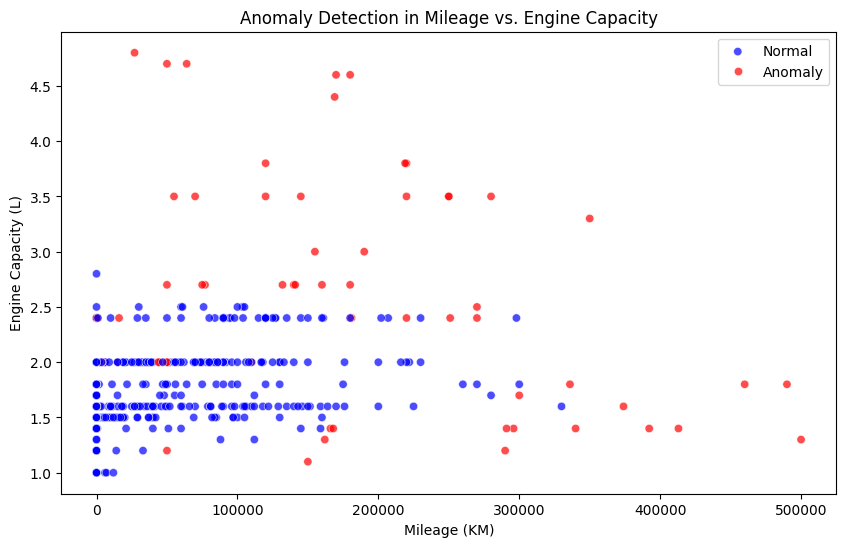

In [53]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["Mileage (KM)"], y=df["Engine Capacity (L)"], hue=df_cleaned["Anomaly"], palette={1: 'blue', -1: 'red'}, alpha=0.7)
plt.xlabel("Mileage (KM)")
plt.ylabel("Engine Capacity (L)")
plt.title("Anomaly Detection in Mileage vs. Engine Capacity")
plt.legend(["Normal", "Anomaly"])
plt.show()


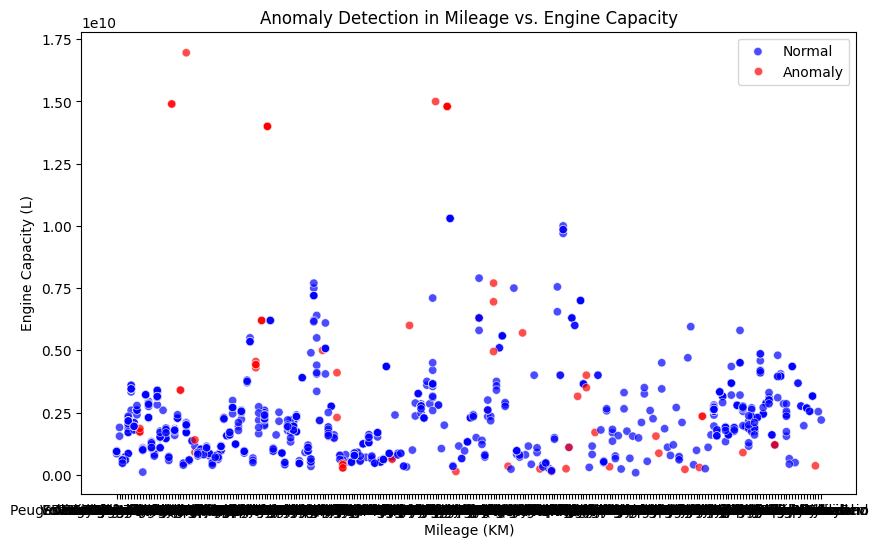

In [54]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["Car Name"], y=df["Price"], hue=df_cleaned["Anomaly"], palette={1: 'blue', -1: 'red'}, alpha=0.7)
plt.xlabel("Mileage (KM)")
plt.ylabel("Engine Capacity (L)")
plt.title("Anomaly Detection in Mileage vs. Engine Capacity")
plt.legend(["Normal", "Anomaly"])
plt.show()


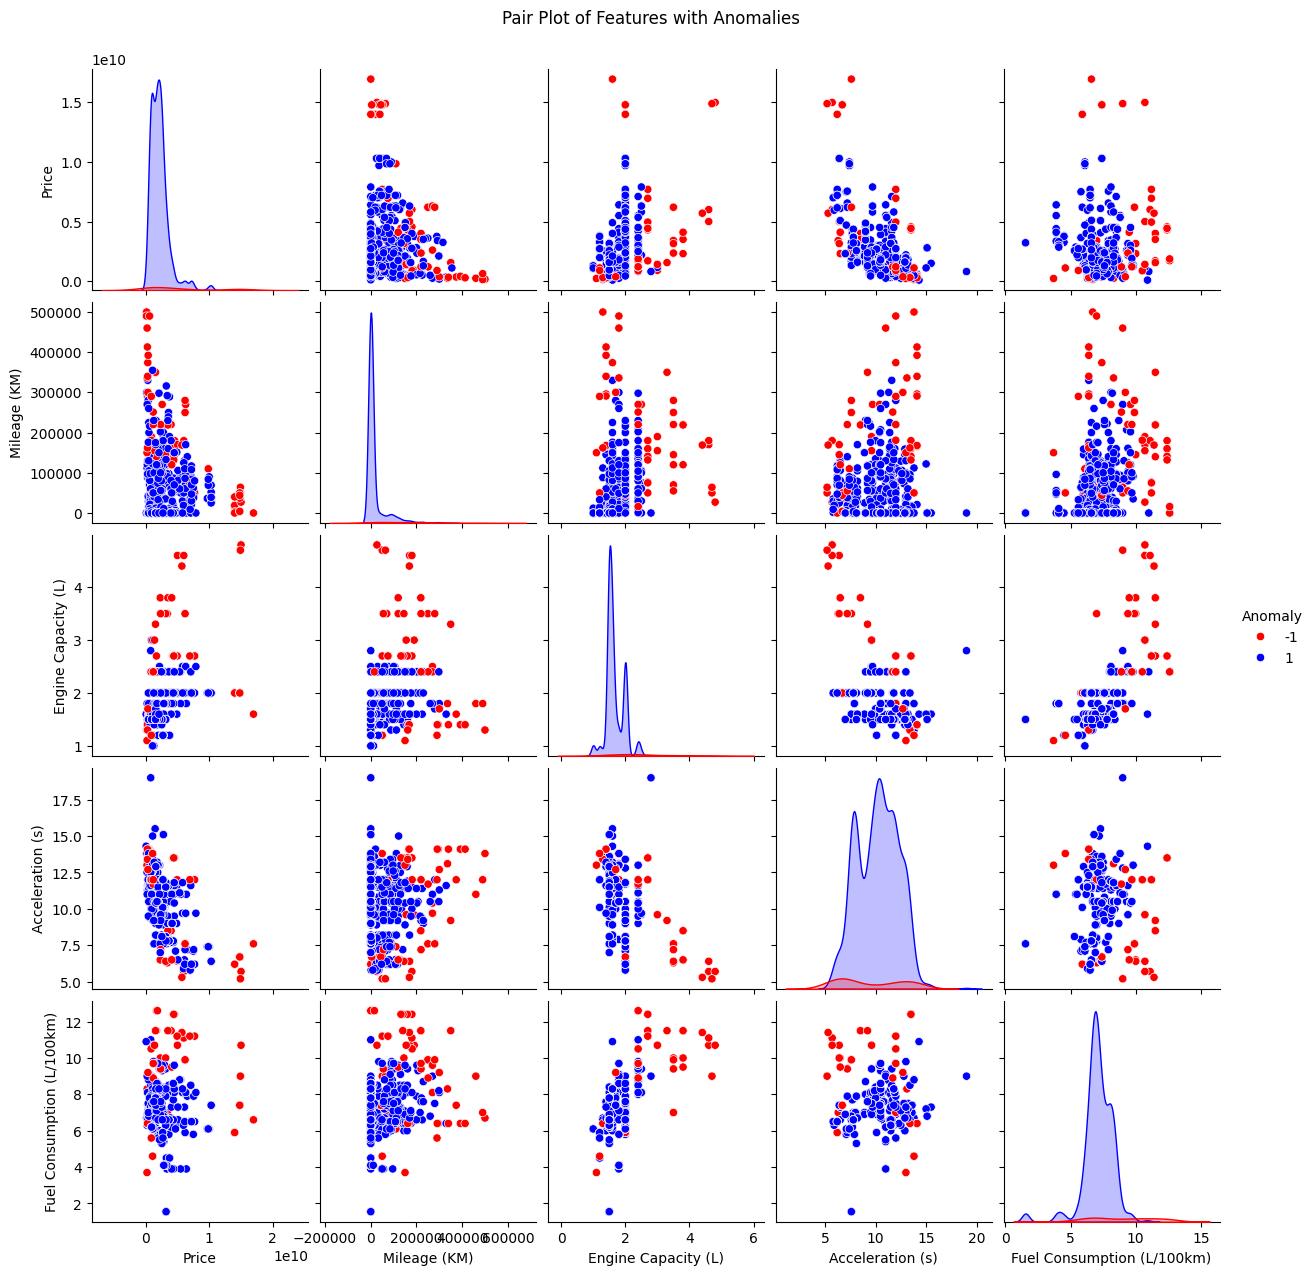

In [55]:
sns.pairplot(df, vars=['Price',"Mileage (KM)", "Engine Capacity (L)", "Acceleration (s)", "Fuel Consumption (L/100km)"], hue="Anomaly", palette={1: "blue", -1: "red"}, diag_kind="kde")
plt.suptitle("Pair Plot of Features with Anomalies", y=1.02)
plt.show()


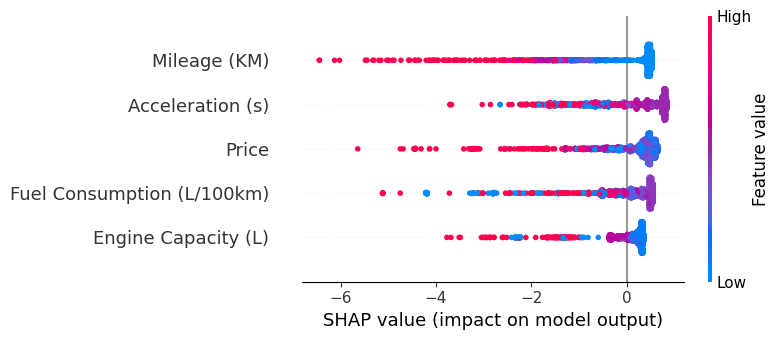

In [58]:
import shap

# Initialize SHAP explainer for Isolation Forest
explainer = shap.Explainer(iso_forest, df_numeric)

# Compute SHAP values
shap_values = explainer(df_numeric)

# Visualize feature impact
shap.summary_plot(shap_values, df_numeric)


In [59]:
shap_importance = pd.DataFrame({
    "Feature": df_numeric.columns,
    "Mean SHAP Value": np.abs(shap_values.values).mean(axis=0)
}).sort_values(by="Mean SHAP Value", ascending=False)

print(shap_importance)


                      Feature  Mean SHAP Value
1                Mileage (KM)         0.761650
3            Acceleration (s)         0.722110
0                       Price         0.572916
4  Fuel Consumption (L/100km)         0.535887
2         Engine Capacity (L)         0.396456


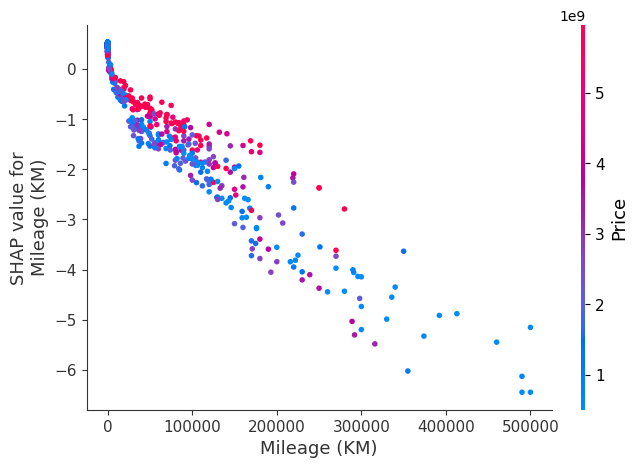

In [61]:
shap.dependence_plot("Mileage (KM)", shap_values.values, df_numeric)


In [67]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [69]:
df = df_cleaned.dropna(subset=["Car Name", "Car Year", "Price", "پیشرانه"]).copy()
len(df)

1334

In [70]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
engine_encoded = ohe.fit_transform(df[['پیشرانه']])
engine_encoded_df = pd.DataFrame(engine_encoded, columns=ohe.get_feature_names_out(['پیشرانه']))


In [71]:
# Merge encoded features and drop original column
df = pd.concat([df.reset_index(drop=True), engine_encoded_df], axis=1).drop(columns=['پیشرانه'])

# Select features for similarity calculation
features = ["Mileage (KM)", "Engine Capacity (L)", "Acceleration (s)", "Fuel Consumption (L/100km)", "Price"] + list(engine_encoded_df.columns)
df_filtered = df.dropna(subset=features).copy()

In [72]:
# Standardize numerical features
scaler = StandardScaler()
df_filtered[features] = scaler.fit_transform(df_filtered[features])

# Compute similarity matrix
similarity_matrix = cosine_similarity(df_filtered[features])
similarity_df = pd.DataFrame(similarity_matrix, index=df_filtered.index, columns=df_filtered.index)

In [76]:
def recommend_similar_cars(car_index, top_n=5):
    if car_index not in similarity_df.index:
        return df_filtered.sample(n=top_n)[["Car Name", "Car Year", "Price", "Mileage (KM)"]]
    
    similar_cars = similarity_df.loc[car_index].sort_values(ascending=False)[1:top_n+1]
    return df_filtered.loc[similar_cars.index, ["Car Name", "Car Year", "Price", "Mileage (KM)"]]


In [77]:
car_index = 10
print(recommend_similar_cars(car_index))

                          Car Name  Car Year     Price  Mileage (KM)
1071  Toyota Prado2Doors 4Cylinder    2012.0  0.764390      1.371842
1034            Nissan Qashqai 2Wd    2024.0  0.555666     -0.496872
1291               hyundai-elantra    2014.0 -0.307059      1.201959
606            Renault Talisman E3    2018.0  0.595423     -0.284518
274                   Tara V1P 6Mt    2024.0 -0.638631     -0.496872


In [78]:
car_index = 20  # Change this to any index in the dataset
print(recommend_similar_cars(car_index))


                  Car Name  Car Year     Price  Mileage (KM)
1303  suzuki-grandvitarair    2012.0 -0.517770      2.617650
1187  suzuki-grandvitarair    2012.0 -0.521746      3.056515
1146    hyundai-tucsonix35    2013.0  0.794207      1.626666
919        Geely Emgrandx7    2014.0 -0.650956      2.065531
880       Toyota Camry Glx    2008.0 -0.159958      3.721890


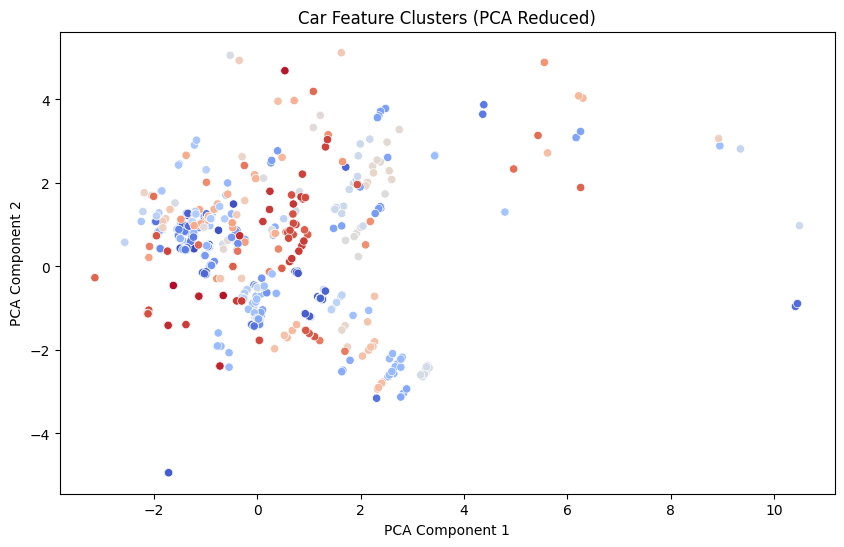

In [79]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_filtered[features])

# Scatter plot of cars based on PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_filtered["Car Name"], palette="coolwarm", legend=False)
plt.title("Car Feature Clusters (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


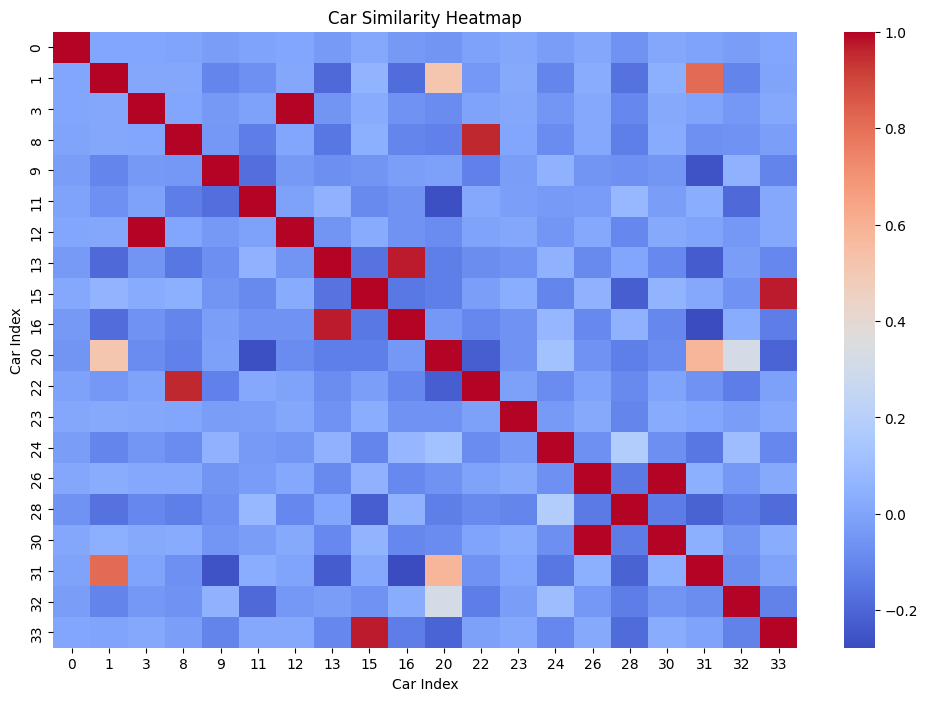

In [86]:

# Select a subset for visualization (too many cars will clutter the heatmap)
subset_size = 20  # Adjust this for a larger/smaller subset
similarity_subset = similarity_df.iloc[:subset_size, :subset_size]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(similarity_subset, cmap="coolwarm", annot=False)
plt.title("Car Similarity Heatmap")
plt.xlabel("Car Index")
plt.ylabel("Car Index")
plt.show()
